In [1]:
import pandas as pd
import numpy as np
from matplotlib import dates
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Activation
from keras.layers import Dense
import matplotlib.pyplot as plt
from numpy.random import seed
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import MultipleLocator
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import matplotlib.dates as mdate
from keras.layers import Dropout
import sherpa

Using TensorFlow backend.
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as

# Read input files

In [2]:
def read_inputfiles():
    meterology = pd.read_excel("meteorlogy_daily.xlsx")
    surface_temp = pd.read_csv("Surface_Temperature_without_remove.csv", usecols=['Date', 'Sup.', 'Huron'], 
                               dtype= {'Sup.':float, 'Huron':float})
    ice_data = pd.read_excel("Ice_Data_without_remove.xlsx")
    climate_indices = pd.read_csv("climate_ind_daily.csv")
    
    return meterology, surface_temp, ice_data, climate_indices

# Prepare input and output data

In [3]:
def prepare_input_data(look_back, num_features, predict_interval, meterology, surface_temp, ice_data):
    merged_df = meterology
    merged_df['Sup.'] = 0.0
    merged_df['Huron'] = 0.0
    merged_df['NAO'] = 0.0
#     merged_df['PNA'] = 0.0
#     merged_df['EPNP'] = 0.0
#     merged_df['SOI'] = 0.0
    merged_df['ice'] = 0.0
    merged_df_date = merged_df['date']
    merged_df.drop(['date'], inplace = True, axis = 1)


    # insert water surface temperature data into the dataframe
    for i in range(len(merged_df)):
        merged_df['Sup.'][i] = surface_temp['Sup.'][i] 
        merged_df['Huron'][i] = surface_temp['Huron'][i] 
        merged_df['NAO'][i] = climate_indices['NAO'][i]
#         merged_df['PNA'][i] = climate_indices['PNA'][i]
#         merged_df['EPNP'][i] = climate_indices['EPNP'][i]
#         merged_df['SOI'][i] = climate_indices['SOI'][i]
        merged_df['ice'][i] = ice_data['Ice'][i]
        
#     merged_df.drop(['u-wind', 'v-wind', 'pressure'], axis = 1, inplace = True)
    
    frames = [merged_df_date]
    # store original column name
    columns_name = merged_df.columns
    
    # Remove the last several records
    for i in range(look_back):
        # restore the original column name
        merged_df.columns = columns_name
        # rename the column
        for index, col in merged_df.iteritems():
            merged_df.rename(columns={index: index + "_" + str(i)}, inplace=True)
        frames.append(merged_df.shift(-i))

    # linear
    train_df = pd.concat(frames, axis=1)
    train_df.drop(index = train_df.tail(look_back).index, inplace = True)

#     # add day of year
#     col_name = train_df.columns.tolist()
#     for i in range(look_back-1,-1,-1):
#         col_name.insert(1+(i+1)*num_features, 'dayofyear_' + str(i))
        
#     train_df = train_df.reindex(columns=col_name)

#     for i in range(look_back): 
#         train_df['dayofyear_' + str(look_back-i-1)] = (train_df['date'] + pd.DateOffset(days = i)).dt.dayofyear

    return train_df

In [4]:
def prepare_output_data(ice_data):
    ice_data = ice_data.drop(list(range(0,look_back + predict_interval - 1)))
    
    return ice_data

# Normalization

In [5]:
def normalize_input_data(train_df):
    # normalize the input data
    # minus and plus 1

    scaler_train = MinMaxScaler(feature_range=(0,1))
    input_columns = train_df.iloc[:,1:].columns
    standard_array = scaler_train.fit_transform(train_df.iloc[:,1:].values) 
    train_df_norm = pd.DataFrame(standard_array)
    train_df_norm.columns = input_columns

    # reset the index for the date dataframe
    train_df_norm = pd.concat([train_df.iloc[:,0].to_frame().reset_index(drop=True), train_df_norm], axis = 1)
    train_df_norm.head()
    
    return train_df_norm, scaler_train

In [6]:
def normalize_output_data(ice_data):
    scaler_test = MinMaxScaler(feature_range=(0,1))
    input_columns = ice_data.iloc[:,1:].columns
    standard_array = scaler_test.fit_transform(ice_data.iloc[:,1:].values) 
    test_df = pd.DataFrame(standard_array)
    test_df.columns = input_columns
    
    test_df_norm = pd.concat([ice_data.iloc[:,0].to_frame().reset_index(drop=True), test_df], axis = 1)
    
    return test_df_norm, scaler_test

# Divide training set, validation set and test set

In [7]:
# Dividing training set and test set
def divide_data_set(train_df_norm, test_df_norm):
    # convert to array
    train_df_norm = train_df_norm.values
    test_df_norm = test_df_norm.values
    
    # Dividing data from 1995 to 2010 as training set
    # Dividing data from 2011 to 2015 as training set
    # Dividing data from 2016 to 2021/6/30 as test set
    

    for i in range(0, len(test_df_norm)):
        if (test_df_norm[i][0] ==  datetime(2010,12,31,0,0,0)):
            num_test = i
        if (test_df_norm[i][0] == datetime(2015,12,31,0,0,0)):
            num_validation_test = i

    entire_trainX = train_df_norm[0:num_test+1,1:]
    entire_trainY = test_df_norm[0:num_test+1,[1]]
    entire_validX = train_df_norm[num_test+1:num_validation_test+1,1:]
    entire_validY = test_df_norm[num_test+1:num_validation_test+1, [1]]
    entire_testX = train_df_norm[num_validation_test+1:test_df_norm.shape[0],1:]
    entire_testY = test_df_norm[num_validation_test+1:test_df_norm.shape[0],[1]]
    
    # Reshape the data
    # (Samples、Timesteps、Features)
    entire_trainX = np.reshape(entire_trainX, (entire_trainX.shape[0], look_back, num_features))
    entire_validX = np.reshape(entire_validX, (entire_validX.shape[0], look_back, num_features))
    entire_testX = np.reshape(entire_testX, (entire_testX.shape[0], look_back, num_features))
    
    return entire_trainX, entire_trainY, entire_validX, entire_validY, entire_testX, entire_testY, num_test, num_validation_test

# Feature Selection

In [8]:
def feature_selection(entire_trainY):
    feature_trainY = np.array(entire_trainY, dtype=float)
    feature_trainY = np.reshape(feature_trainY, (feature_trainY.shape[0]))

    model_selection = SelectKBest(f_regression, k=2)

    feature_selection_result = model_selection.fit_transform(entire_trainX, feature_trainY)
    # feature_result = model_selection.scores_
    feature_result = pd.DataFrame(model_selection.scores_)
    
    feature_result.index = train_df.columns[1:]
    feature_result.columns = ["score"]
    feature_result = feature_result.sort_values(by="score" , ascending=False)
    
    return feature_result

# Function used to detect overfitting in the validation set

In [9]:
# Function used for drawing loss curve

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_accuracy = {'batch': [], 'epoch': []}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('mse'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_accuracy['batch'].append(logs.get('val_mse'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('mse'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_accuracy['epoch'].append(logs.get('val_mse'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
#         plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_accuracy[loss_type], 'b', label='val acc')
            # val_loss
#             plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

# Build LSTM model

In [10]:
# Build the LSTM model
def LSTM_model(look_back, num_features, 
               trainX, validX, testX, 
               trainY, validY, testY,
               scaler_test):

    batch_size = 32
    model = Sequential() 
    model.add(LSTM(units=50,activation='softsign', input_shape=(look_back, num_features)))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer ='RMSProp', metrics=['mse'])
    history = LossHistory()
    model.fit(trainX, trainY, epochs=100, validation_data=(validX,validY), batch_size=batch_size, verbose=0, callbacks = [history])
    history.loss_plot('epoch')
    
    trainPredict = model.predict(trainX)
    validPredict = model.predict(validX)
    testPredict = model.predict(testX)
    
    # Turn the normalized data back to normal data

    trainPredict = scaler_test.inverse_transform(trainPredict)
    trainY = scaler_test.inverse_transform(trainY)
    validPredict = scaler_test.inverse_transform(validPredict)
    validY = scaler_test.inverse_transform(validY)
    testPredict = scaler_test.inverse_transform(testPredict)
    testY = scaler_test.inverse_transform(testY)


    # remove anomalous data in the predict list
    for i in range(0, len(trainPredict)):
        if trainPredict[i] < 0:
            trainPredict[i] = 0
        if trainPredict[i] > 100:
            trainPredict[i] = 100

            
    for i in range(0, len(validPredict)):
        if validPredict[i] < 0:
            validPredict[i] = 0
        if validPredict[i] > 100:
            validPredict[i] = 100
            
    # remove anomalous data in the test list
    for i in range(0, len(testPredict)):
        if testPredict[i] < 0:
            testPredict[i] = 0
        if testPredict[i] > 100:
            testPredict[i] = 100
            
    trainScore2 = np.sqrt(mean_squared_error(trainY, trainPredict))
    testScore2 = np.sqrt(mean_squared_error(testY, testPredict))
    
    return trainPredict, trainY, testPredict, testY, validPredict, validY

#     return trainScore2, testScore2, trainPredict, trainY, testPredict, testY, validPredict, validY

# Draw time series plot

In [11]:
# Create data for drawing plots

def draw_time_series_plot(train_df_norm, num_test, num_validation_test, trainY, trainPredict, testY, testPredict):
    date_list_train = train_df_norm.iloc[0:num_test+1]['date'].tolist()
    # test set without validation data
    # date_list_test = test_df[num+1:train_df.shape[0],[0]].tolist()

    # test set with validation data
    date_list_test = train_df_norm.iloc[num_validation_test+1:test_df_norm.shape[0]]['date'].tolist()
    date_plot_list_test  = []
    date_plot_list_train = []
    test_plot_list = []
    train_plot_list = []
    predict_plot_list_train = []
    predict_plot_list_test = []

    for i in range(0, len(date_list_train)):
        date_list_train[i] = [date_list_train[i].strftime("%Y-%m-%d")]
        date_plot_list_train.append(date_list_train[i][0])
        train_plot_list.append(trainY[i][0])
        predict_plot_list_train.append(trainPredict[i][0])

    for i in range(0, len(date_list_test)):
        date_list_test[i] = [date_list_test[i].strftime("%Y-%m-%d")]
        date_plot_list_test.append(date_list_test[i][0])
        test_plot_list.append(testY[i][0])
        predict_plot_list_test.append(testPredict[i][0])
        
    # Draw predict data and test data for the set set

    tick_spacing = 5
    plt.figure(figsize=(20,10))
    xValue1 = date_plot_list_test
    yValue1 = test_plot_list
    yValue2 = predict_plot_list_test
    # xValue2 = date_plot_list_train
    # yValue3 = train_plot_list
    # yValue4 = predict_plot_list_train
    # yValue5 = base_line_plot

    # p3, = plt.plot(xValue2, yValue3)
    # p4, = plt.plot(xValue2, yValue4)

    p1, = plt.plot(xValue1, yValue1)
    p2, = plt.plot(xValue1, yValue2)
    # p3, = plt.plot(xValue1, yValue5)

    ax=plt.gca()
    x_major_locator=MultipleLocator(365)
    # ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m')) 
    ax.xaxis.set_major_locator(x_major_locator)



    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.legend([p1, p2], ["actual ice cover ", "predicted ice cover", "baseline"], loc='lower left', fontsize=15)
    # plt.legend([p3, p4], ["Original Train Data", "Predict Train Data"], loc='lower left')
    plt.show()
        
#     return date_plot_list, train_plot_list, predict_plot_list, date_plot_list_test, test_plot_list, predict_plot_list_test

# Draw ice-on and ice-off plot

In [12]:
# Get ice_on and ice_off date 

def draw_ice_on_off_plot(trainPredict, validPredict, testPredict, train_df, test_df_norm):
    train_predict_df = pd.DataFrame(trainPredict)
    valid_predict_df = pd.DataFrame(validPredict)
    test_predict_df = pd.DataFrame(testPredict)
    frames = [train_predict_df, valid_predict_df, test_predict_df]
    test_predict_df = pd.concat(frames, axis=0)
    test_predict_df = test_predict_df.reset_index(drop=True)

    test_predict_df.rename(columns={0:'Ice_concentration'}, inplace = True)
    date_df = test_df_norm.iloc[0:train_df.shape[0]]['date']
    date_df = pd.DataFrame(date_df)
    frames = [date_df, test_predict_df]

    test_predict_df = pd.concat(frames,  axis=1)
    test_predict_df.rename(columns={0:'Date'}, inplace = True)

    ice_on_date = []
    ice_off_date = []
    no_ice_date = []
    # year in test set
    year_list = []


    for i in range(0, len(test_predict_df['Ice_concentration'])):
        if(i == 0):
            mean = (test_predict_df['Ice_concentration'][i] + test_predict_df['Ice_concentration'][i+1] + test_predict_df['Ice_concentration'][i+2])/3
        elif(i == len(test_predict_df['Ice_concentration'])-1):
            mean = (test_predict_df['Ice_concentration'][i] + test_predict_df['Ice_concentration'][i-1] + test_predict_df['Ice_concentration'][i-2])/3
        else:
            mean = (test_predict_df['Ice_concentration'][i] + test_predict_df['Ice_concentration'][i-1] + test_predict_df['Ice_concentration'][i+1])/3
        if(mean < 10):
            no_ice_date.append(test_predict_df['date'][i])

    ice_off_date.append(no_ice_date[0])
    for i in range(0, len(no_ice_date)-1):
        if(no_ice_date[i] + timedelta(days = 1) != no_ice_date[i+1]):
            ice_on_date.append(no_ice_date[i]+timedelta(days = 1))
            ice_off_date.append(no_ice_date[i+1])
    ice_on_date.append(no_ice_date[-1])

    for i in ice_off_date:
        year_list.append(int(i.strftime("%Y")))


    data = {'Year': year_list,
            'Ice-off Date': ice_off_date,
            'Ice-on Date': ice_on_date}

    df = DataFrame(data)
    df = df.reset_index(drop=True)

    # Draw the Ice-on and Ice-off plots

    df_original = pd.read_excel("d:/Jupyter/time_series/Ice_Duration.xlsx",  header = 0)
    predict_interval = 7

    xValue_original = []
    yValue_original = []
    xValue = []
    yValue = []
    tick_spacing = 5

    for i in range(1,len(df_original['Year'])):
        if(int(df_original['Ice-off Date'][i].strftime("%m")) < 11):
            xValue_original.append(df_original['Year'][i])
            xValue_original.append(df_original['Year'][i])
        else:
            xValue_original.append(df_original['Year'][i]+1)
            xValue_original.append(df_original['Year'][i]+1)

    for i in range(1,len(df['Year'])):
        if(int(df['Ice-off Date'][i].strftime("%m")) < 11):
            xValue.append(df['Year'][i])
            xValue.append(df['Year'][i])
        else:
            xValue.append(df['Year'][i]+1)
            xValue.append(df['Year'][i]+1)



    for i in range(0,(len(df_original['Ice-off Date'])-1)):
        if(int(df_original['Ice-on Date'][i].strftime("%m")) >= 11):
            start_date = datetime(int(df_original['Ice-on Date'][i].strftime("%Y")),11,1,0,0,0)
        yValue_original.append((df_original['Ice-on Date'][i]-start_date).days)
        yValue_original.append((df_original['Ice-off Date'][i+1]-start_date).days)

    for i in range(0,(len(df['Ice-off Date'])-1)):
        if(int(df['Ice-on Date'][i].strftime("%m")) >= 11):
            start_date = datetime(int(df['Ice-on Date'][i].strftime("%Y")),11,1,0,0,0)
        else:
            start_date = datetime(int(df['Ice-on Date'][i].strftime("%Y"))-1,11,1,0,0,0)
        yValue.append((df['Ice-on Date'][i]-start_date).days)
        yValue.append((df['Ice-off Date'][i+1]-start_date).days)



    plt.figure(figsize=(16,8))  

    for i in range(0, int(len(xValue)/2)):
        plt.annotate(df['Ice-on Date'][i].strftime("%Y-%m-%d"),(xValue[2*i],yValue[2*i]), xytext=(xValue[2*i]+0.25,yValue[2*i] -2), fontsize=8)



    for i in range(0, int(len(xValue_original)/2)):
        if(i==0):
            line1 = plt.plot([xValue_original[2*i], xValue_original[2*i+1]],[yValue_original[2*i], yValue_original[2*i+1]],  color ='k', label = 'Original')

        line1 = plt.plot([xValue_original[2*i], xValue_original[2*i+1]],[yValue_original[2*i], yValue_original[2*i+1]],  color ='k')

    plt.legend()


    for j in range(0, int(len(xValue)/2)):
        if(j == 0):
            line2 = plt.plot([xValue[2*j] + 0.3, xValue[2*j+1]+0.3],[yValue[2*j], yValue[2*j+1]], label = 'predicted', color = 'r')

        line2 = plt.plot([xValue[2*j] + 0.3, xValue[2*j+1]+0.3],[yValue[2*j], yValue[2*j+1]], color = 'r')  

    plt.legend(loc='upper right', fontsize = 12)


    plt.title('Ice Season Duration with ' + str(predict_interval) + ' Predict Interval' , fontsize=20)

    plt.yticks([])


    frame = plt.gca().axes.get_xaxis().set_visible(False)

    plt.savefig('ice-on.png')

# Run the LSTM model

In [13]:
# lag_time (unit: daily)
# look_back = 5
predict_interval = 30
# number of features
num_features = 9

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


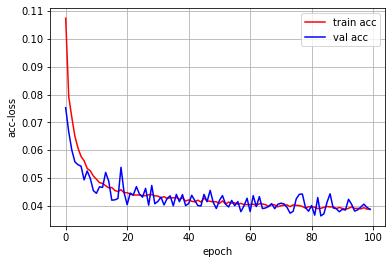

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


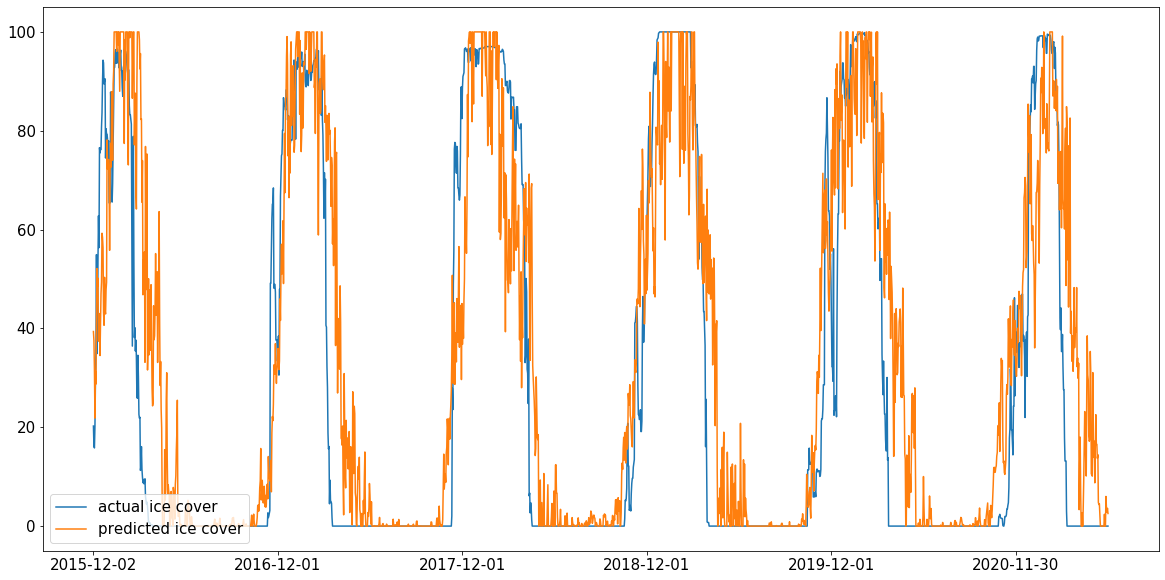

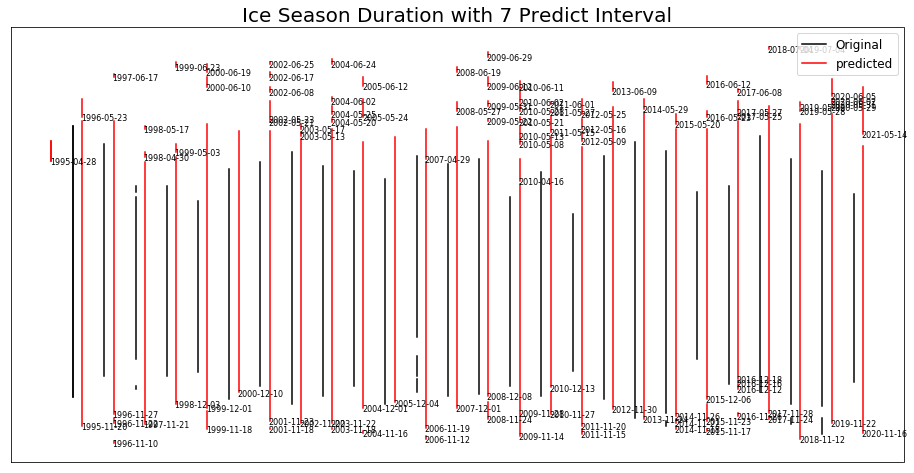

In [14]:
# Build and run LSTM model pipeline

lag_dict = {}
lag_list = []

candidate_lag = [7]

for look_back in candidate_lag:
    meterology, surface_temp, ice_data, climate_indices = read_inputfiles()
    train_df = prepare_input_data(look_back, num_features, predict_interval, meterology, surface_temp, ice_data)
    ice_data = prepare_output_data(ice_data)
    train_df_norm, scaler_train = normalize_input_data(train_df)
    test_df_norm, scaler_test = normalize_output_data(ice_data)
    # feature_result = feature_selection(entire_trainY)
    entire_trainX, entire_trainY, entire_validX, entire_validY, \
    entire_testX, entire_testY, num_test, num_validation_test = divide_data_set(train_df_norm, test_df_norm)

    trainPredict, trainY, testPredict, testY, validPredict, validY = LSTM_model(look_back, num_features, 
                                                                                 entire_trainX,  entire_validX, entire_testX, 
                                                                                 entire_trainY, entire_validY, entire_testY, 
                                                                                 scaler_test)
    draw_time_series_plot(train_df_norm, num_test, num_validation_test, trainY, trainPredict, testY, testPredict)
    draw_ice_on_off_plot(trainPredict, validPredict, testPredict, train_df, test_df_norm)
    
    
#     lag_dict[look_back] = rmse_test
#     lag_list.append(rmse_test)

# Calculate RMSE and MAE for freezing/stable/melting period

In [15]:
def get_ice_period_index(df):
    
    # Dividing three phases
    freezing_season = []
    mid_season = []
    melting_season = []

    freezing_season_train = []
    mid_season_train = []
    melting_season_train = []
    freezing_season_validation = []
    mid_season_validation = []
    melting_season_validation = []
    freezing_season_test = []
    mid_season_test = []
    melting_season_test = []
    summer_season = []
    
    res_list = [freezing_season_train, mid_season_train, melting_season_train, freezing_season_validation,
               mid_season_validation, melting_season_validation, freezing_season_test, mid_season_test, 
                melting_season_test, summer_season]
    
    for index, row in df.iterrows():
        if(row['date'].strftime("%m-%d") >= '11-01' or row['date'].strftime("%m-%d") <= "01-14"):
            freezing_season.append(index)
        elif(row['date'].strftime("%m-%d") >= "01-15" and row['date'].strftime("%m-%d") <= "03-25"):
            mid_season.append(index)
        elif(row['date'].strftime("%m-%d") >= "03-26" and row['date'].strftime("%m-%d") <= "05-20"):
            melting_season.append(index)
        if(row['date'].strftime("%m-%d") >= '11-01' or row['date'].strftime("%m-%d") <= "05-20"):
            summer_season.append(index)
        
    for i in freezing_season:
        if(df['date'][i].strftime("%Y") <= '2010'):
            freezing_season_train.append(i)
        elif(df['date'][i].strftime("%Y") >= '2011' and df['date'][i].strftime("%Y") <= '2015'):
            freezing_season_validation.append(i)
        else:
            freezing_season_test.append(i)
           
    for i in mid_season:
        if(df['date'][i].strftime("%Y") <= '2010'):
            mid_season_train.append(i)
        elif(df['date'][i].strftime("%Y") >= '2011' and df['date'][i].strftime("%Y") <= '2015'):
            mid_season_validation.append(i)
        else:
            mid_season_test.append(i)

    for i in melting_season:
        if(df['date'][i].strftime("%Y") <= '2010'):
            melting_season_train.append(i)
        elif(df['date'][i].strftime("%Y") >= '2011' and df['date'][i].strftime("%Y") <= '2015'):
            melting_season_validation.append(i)
        else:
            melting_season_test.append(i)
            
    return res_list

In [18]:
predict_df_list = [pd.DataFrame(trainPredict), pd.DataFrame(validPredict), pd.DataFrame(testPredict)]
predict_df = pd.concat(predict_df_list)
date_test =  pd.DataFrame(test_df_norm['date'])
date_test['predict'] = predict_df[0].values
ice_data = pd.read_excel("Ice_Data_without_remove.xlsx")
ice_data = prepare_output_data(ice_data)


ice_period_original = get_ice_period_index(ice_data)
ice_period_predict = get_ice_period_index(date_test)
        
# Get the accuracy for the training data
freezing_predict = date_test.loc[ice_period_predict[0]]
mid_predict = date_test.loc[ice_period_predict[1]]
melting_predict = date_test.loc[ice_period_predict[2]]
freezing_test = ice_data.loc[ice_period_original[0]]
mid_test = ice_data.loc[ice_period_original[1]]
melting_test = ice_data.loc[ice_period_original[2]]

freezing_rmse = np.sqrt(mean_squared_error(freezing_predict['predict'], freezing_test['Ice']))
freezing_mae = mean_absolute_error(freezing_predict['predict'], freezing_test['Ice'])
mid_rmse = np.sqrt(mean_squared_error(mid_predict['predict'], mid_test['Ice']))
mid_mae = mean_absolute_error(mid_predict['predict'], mid_test['Ice'])
melting_rmse = np.sqrt(mean_squared_error(melting_predict['predict'], melting_test['Ice']))
melting_mae = mean_absolute_error(melting_predict['predict'], melting_test['Ice'])
entire_rmse = np.sqrt(mean_squared_error(trainY, trainPredict))
entire_mae = mean_absolute_error(trainY, trainPredict)
    
dict_data_train = {'RMSE_train': [freezing_rmse, mid_rmse, melting_rmse, entire_rmse, baseline_rmse], 
             'MAE_train': [freezing_mae, mid_mae, melting_mae, entire_mae, baseline_mae]}
ice_season_df = pd.DataFrame(dict_data_train, index = ['freezing', 'stable', 'melting', 'entire', 'baseline'])
print(ice_season_df)

# Get the accuracy for the validation data
freezing_predict = date_test.loc[ice_period_predict[3]]
mid_predict = date_test.loc[ice_period_predict[4]]
melting_predict = date_test.loc[ice_period_predict[5]]
freezing_test = ice_data.loc[ice_period_original[3]]
mid_test = ice_data.loc[ice_period_original[4]]
melting_test = ice_data.loc[ice_period_original[5]]

freezing_rmse = np.sqrt(mean_squared_error(freezing_predict['predict'], freezing_test['Ice']))
freezing_mae = mean_absolute_error(freezing_predict['predict'], freezing_test['Ice'])
mid_rmse = np.sqrt(mean_squared_error(mid_predict['predict'], mid_test['Ice']))
mid_mae = mean_absolute_error(mid_predict['predict'], mid_test['Ice'])
melting_rmse = np.sqrt(mean_squared_error(melting_predict['predict'], melting_test['Ice']))
melting_mae = mean_absolute_error(melting_predict['predict'], melting_test['Ice'])
entire_rmse = np.sqrt(mean_squared_error(validY, validPredict))
entire_mae = mean_absolute_error(validY, validPredict)
    
dict_data_validation = {'RMSE_validation': [freezing_rmse, mid_rmse, melting_rmse, entire_rmse, baseline_rmse], 
             'MAE_validation': [freezing_mae, mid_mae, melting_mae, entire_mae, baseline_mae]}
ice_season_df = pd.DataFrame(dict_data_validation, index = ['freezing', 'stable', 'melting', 'entire', 'baseline'])
print(ice_season_df)
    
# Get the accuracy for the test data
freezing_predict = date_test.loc[ice_period_predict[6]]
mid_predict = date_test.loc[ice_period_predict[7]]
melting_predict = date_test.loc[ice_period_predict[8]]
freezing_test = ice_data.loc[ice_period_original[6]]
mid_test = ice_data.loc[ice_period_original[7]]
melting_test = ice_data.loc[ice_period_original[8]]

freezing_rmse = np.sqrt(mean_squared_error(freezing_predict['predict'], freezing_test['Ice']))
freezing_mae = mean_absolute_error(freezing_predict['predict'], freezing_test['Ice'])
mid_rmse = np.sqrt(mean_squared_error(mid_predict['predict'], mid_test['Ice']))
mid_mae = mean_absolute_error(mid_predict['predict'], mid_test['Ice'])
melting_rmse = np.sqrt(mean_squared_error(melting_predict['predict'], melting_test['Ice']))
melting_mae = mean_absolute_error(melting_predict['predict'], melting_test['Ice'])
entire_rmse = np.sqrt(mean_squared_error(testY, testPredict))
entire_mae = mean_absolute_error(testY, testPredict)

dict_data_test = {'RMSE': [freezing_rmse, mid_rmse, melting_rmse, entire_rmse, baseline_rmse], 
             'MAE': [freezing_mae, mid_mae, melting_mae, entire_mae, baseline_mae]}
ice_season_df = pd.DataFrame(dict_data_test, index = ['freezing', 'stable', 'melting', 'entire', 'baseline'])
print(ice_season_df)

          RMSE_train  MAE_train
freezing   23.071361  17.100126
stable     21.596926  16.305566
melting    28.812731  22.787261
entire     18.266349  10.750040
baseline   14.820116   7.083369
          RMSE_validation  MAE_validation
freezing        19.605697       14.606121
stable          15.106689       10.465975
melting         36.792978       29.349102
entire          18.656795       10.411879
baseline        14.820116        7.083369
               RMSE        MAE
freezing  20.625520  14.986829
stable    17.151972  12.207967
melting   39.421377  33.796075
entire    20.537910  12.214901
baseline  14.820116   7.083369


In [58]:
date_test =  pd.DataFrame(test_df_norm.iloc[num_validation_test+1:test_df_norm.shape[0]]['date'])
baseline_df = date_test.reset_index(drop=True)
baseline_df['baseline'] = baseline_plot['baseline']
baseline_index = get_ice_period_index(baseline_df)


# Get the accuracy for the baseline data
freezing_baseline = baseline_df.loc[baseline_index[6]]
mid_baseline = baseline_df.loc[baseline_index[7]]
melting_baseline = baseline_df.loc[baseline_index[8]]



freezing_rmse_baseline = np.sqrt(mean_squared_error(freezing_baseline['baseline'], freezing_test['Ice']))
freezing_mae_baseline = mean_absolute_error(freezing_baseline['baseline'], freezing_test['Ice'])
mid_rmse_baseline = np.sqrt(mean_squared_error(mid_baseline['baseline'], mid_test['Ice']))
mid_mae_baseline = mean_absolute_error(mid_baseline['baseline'], mid_test['Ice'])
melting_rmse_baseline = np.sqrt(mean_squared_error(melting_baseline['baseline'], melting_test['Ice']))
melting_mae_baseline = mean_absolute_error(melting_baseline['baseline'], melting_test['Ice'])
dict_data_baseline = {'RMSE': [freezing_rmse_baseline, mid_rmse_baseline, melting_rmse_baseline], 
             'MAE': [freezing_mae_baseline, mid_mae_baseline, melting_mae_baseline]}
ice_season_df = pd.DataFrame(dict_data_baseline, index = ['freezing', 'stable', 'melting'])
print(ice_season_df)

               RMSE        MAE
freezing  18.106479  12.099462
stable    11.770803   6.455796
melting   27.550192  20.215379


# Calculate the baseline

In [17]:
baseline_plot = pd.read_excel("baseline.xlsx")
testY = scaler_test.inverse_transform(entire_testY)
baseline_rmse = np.sqrt(mean_squared_error(testY, baseline_plot['baseline']))
baseline_mae = mean_absolute_error(testY, baseline_plot['baseline'])

In [34]:
# ice_data = pd.read_excel("Ice_Data_without_remove.xlsx")
# date_test =  pd.DataFrame(test_df_norm.iloc[num_validation_test+1:test_df_norm.shape[0]]['date'])

# def calculate_baseline(ice_data, date_test):

#     base_line_plot = []

#     for _, row in date_test.iterrows():
#         month_date = row['date'].strftime("%m-%d")
#         year = row['date'].year
#         date_sum = 0
#         cnt = 0
#         for index, row in ice_data.iterrows():
#             same_date = row['date'].strftime("%m-%d")
#             same_year = row['date'].strftime("%Y")
#             if(same_date == month_date and int(same_year) >= int(year) - 21 and int(same_year) <= int(year) - 5):
#                 date_sum += row['Ice']
#                 cnt += 1
#         average = date_sum/cnt
#         print(average)
#         base_line_plot.append(average)
        
#     return base_line_plot

# testY = scaler_test.inverse_transform(entire_testY)
# testScore = np.sqrt(mean_squared_error(testY, base_line_plot))
# date_test['baseline'] = 0
# date_test['baseline'] = base_line_plot
# date_test.to_excel('baseline.xlsx',index=False,header=True)